# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. Доступен набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li>
    <li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span>
        <ul class="toc-item">
            <li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li>
            <li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li>
        </ul>
    </li>
    <li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>
    <li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Подключим необходимые библиотеки и выставим полезные умолчания.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, PrecisionRecallDisplay, f1_score,
                             precision_recall_curve, average_precision_score)

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows
pd.set_option('display.max_columns', None);  # Display all dataframe columns

In [2]:
# Custom random state
RS = 22221111

Загрузим датасет и взглянем на него.

In [3]:
path = 'toxic_comments.csv'
if not os.path.exists(path):
    path = '/' + path
    if not os.path.exists(path):
        path = 'https://code.s3.yandex.net/datasets' + path
df = pd.read_csv(path)

In [27]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df['toxic'].mean()

0.10167887648758234

В датасете большой дисбаланс классов: токсичных комментариев лишь 10%. Лемматизируем комментарии.

In [6]:
pos_conv = {'v': 'v', 'r': 'r', 'n': 'n', 'j': 'a'}
lm = WordNetLemmatizer()

In [7]:
def my_lemmatize(text):
    return ' '.join([
        lm.lemmatize(word, pos_conv.get(tag[0].lower(), 'n')) for word, tag 
        in nltk.pos_tag(re.sub(r"[^a-zA-Z' ]", ' ', text).lower().split())
    ])

In [ ]:
# Batching is for progress tracking only
N = len(df)
batch_size = math.ceil(N/100)
for batch in tqdm(range(math.ceil(N/batch_size))):
    begin = batch*batch_size
    end = min(begin+batch_size, N)
    df.loc[begin:end, 'lemmas'] = df.loc[begin:end, 'text'].apply(my_lemmatize)

In [9]:
df

,text,toxic,lemmas
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not try to edit war it's ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,NaN
159567,You should be ashamed of yourself \n\nThat is ...,0,NaN
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,NaN
159569,And it looks like it was actually you who put ...,0,NaN


Разобьем датасет на обучающую, валидационную и тестовую выборки. Валидационную выборку будем использовать для подбора порога, а также для контроля над переобучением в модели CatBoost. На тестовой выборке будем проверять качество моделей, которые прошли отбор.

In [7]:
y = df['toxic']

train, eval_test = train_test_split(
    df.index.to_list(), test_size=.2, stratify=y, random_state=RS)

eval, test = train_test_split(
    eval_test, test_size=.5, stratify=y[eval_test], random_state=RS)

print([len(x) for x in (train, eval, test)])
print([y[x].mean() for x in (train, eval, test)])

[127656, 15957, 15958]
[0.10167951369305007, 0.10164817948235884, 0.10170447424489285]


Векторизуем лемматизированные комментарии методом TF-IDF.

In [12]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

X_train = tfidf.fit_transform(df['lemmas'][train])
X_eval = tfidf.transform(df['lemmas'][eval])
X_test = tfidf.transform(df['lemmas'][test])

X_train.shape, X_eval.shape, X_test.shape

((127656, 138231), (15957, 138231), (15958, 138231))

## Обучение

### LogisticRegression

Обучим логистическую регрессию на полученных векторах. При подборе гиперпараметров будем максимизировать площадь под кривой precision–recall (average precision, PR AUC).

In [13]:
c_grid = np.logspace(-3, 0, 7)
# l1_ratio_grid = [.1, .5, .7, .9, .95, .99, 1]
logit_grid = [
    dict(
        penalty=['l1'], 
        solver=['liblinear'], #'saga'],
        C=c_grid,
    ),
    dict(
        penalty=['l2'], 
        solver=['newton-cg', 'lbfgs', 'liblinear'], #'sag', 'saga'],
        C=c_grid,
    ),
    # dict(
    #     penalty=['none'],
    #     solver=['newton-cg', 'lbfgs'], #'sag', 'saga'],
    # ),
    # dict(
    #     penalty=['elasticnet'], 
    #     solver=['saga'],
    #     C=c_grid,
    #     l1_ratio=l1_ratio_grid,
    # ),
]
print('Number of Candidates:',
      sum([np.prod([len(lst) for lst in dct.values()]) for dct in logit_grid]))

Number of Candidates: 28


In [14]:
%%time
logit = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=RS), 
    param_grid=logit_grid,   
    scoring='average_precision', 
    cv=3,
    verbose=10,
    n_jobs=-1,
).fit(X_train, y[train]);

Fitting 3 folds for each of 28 candidates, totalling 84 fits
CPU times: total: 4.59 s
Wall time: 58.2 s


In [36]:
print(f'Logit best mean CV PR AUC: {logit.best_score_:.3f}')
print('Logit best estimator:')
logit.cv_results_['params'][logit.cv_results_['rank_test_score'].argmin()]

Logit best mean CV PR AUC: 0.864
Logit best estimator:


{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Теперь подберем порог, чтобы максимизировать F1 на валидационной выборке.

In [16]:
y_proba_train = logit.predict_proba(X_train)[:, 1]
y_proba_eval = logit.predict_proba(X_eval)[:, 1]

In [17]:
print('Threshold = 0.5:')
print(f'   Logit F1 on train: {f1_score(y[train], y_proba_train >= .5):.3f}')
print(f'   Logit F1 on eval: {f1_score(y[eval], y_proba_eval >= .5):.3f}')

Threshold = 0.5:
   Logit F1 on train: 0.788
   Logit F1 on eval: 0.779


In [18]:
precision, recall, thresholds = precision_recall_curve(y[eval], y_proba_eval)

thr = thresholds[(precision*recall / (precision+recall)).argmax()]

print(f'Threshold = {thr:.2f}:')
print(f'   Logit F1 on train: {f1_score(y[train], y_proba_train >= thr):.3f}')
print(f'   Logit F1 on eval: {f1_score(y[eval], y_proba_eval >= thr):.3f}')

Threshold = 0.34:
   Logit F1 on train: 0.812
   Logit F1 on eval: 0.790


Визуализируем результат.

In [33]:
def my_PrecisionRecallDisplay(y_true, y_proba, threshold, title=None):
    '''Draws precision-recall curve with threshold=0.5 
    and threshold='threshold' points on it'''
    
    fig = PrecisionRecallDisplay.from_predictions(y_true, y_proba).figure_
    fig.suptitle(title);
    fig.set_size_inches(8, 6);
    fig.tight_layout();

    tn, fp, fn, tp = confusion_matrix(y_true, y_proba >= .5).ravel()
    plt.plot(tp/(tp+fn), tp/(tp+fp), 'ro');

    tn, fp, fn, tp = confusion_matrix(y_true, y_proba >= threshold).ravel()
    plt.plot(tp/(tp+fn), tp/(tp+fp), 'bo');

    plt.legend([
        f'PR Curve (PR AUC = {average_precision_score(y_true, y_proba):.3f})', 
        f'Threshold = 0.5 (F1 = {f1_score(y_true, y_proba >= .5):.3f})', 
        f'Threshold = {threshold:.2f} (F1 = {f1_score(y_true, y_proba >= threshold):.3f})'
    ]);
    plt.show();

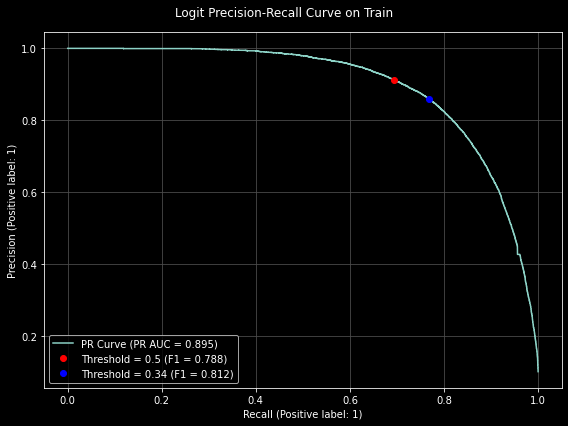

In [34]:
my_PrecisionRecallDisplay(
    y[train], y_proba_train, thr, 'Logit Precision-Recall Curve on Train')

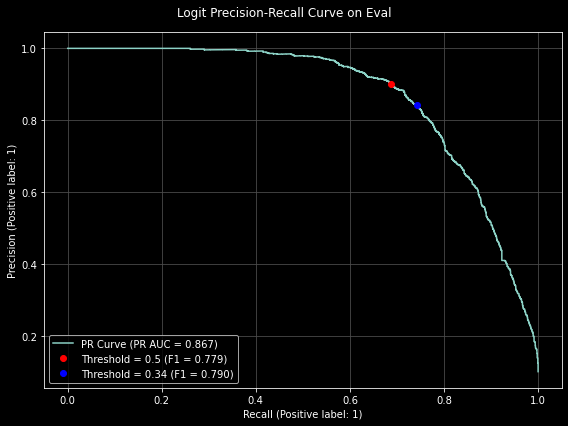

In [35]:
my_PrecisionRecallDisplay(
    y[eval], y_proba_eval, thr, 'Logit Precision-Recall Curve on Eval')

F1 на валидационной выборке превышает 0,75, значит такая модель подходит Викишопу. Сделаем финальную проверку на тестовой выборке. 

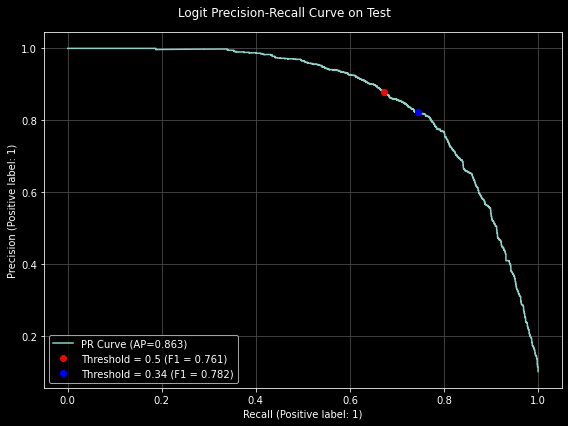

In [22]:
y_proba_test = logit.predict_proba(X_test)[:, 1]
my_PrecisionRecallDisplay(
    y[test], y_proba_test, thr, 'Logit Precision-Recall Curve on Test')

Модель прошла проверку.

### CatBoost

CatBoost умеет работать с текстовыми признаками напрямую: алгоритм векторизует текст самостоятельно. Посмотрим, справится ли он лучше, чем связка TF-IDF–логит.

In [4]:
X = df['text']

In [5]:
params = dict(
    iterations=1000,
    eval_metric='PRAUC',
    custom_metric=['F1'],
    task_type='CPU',
    random_state=RS,
)

In [28]:
cat = CatBoostClassifier(**params).fit(
    X=Pool(X[train].values, y[train], text_features=[0]),
    eval_set=Pool(X[eval].values, y[eval], text_features=[0]),
    use_best_model=True,
    verbose=50,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.104979
0:	learn: 0.6712831	test: 0.6875273	best: 0.6875273 (0)	total: 105ms	remaining: 1m 45s
50:	learn: 0.7647347	test: 0.7828689	best: 0.7828689 (50)	total: 7.69s	remaining: 2m 23s
100:	learn: 0.7828078	test: 0.7950702	best: 0.7950702 (100)	total: 14.9s	remaining: 2m 12s
150:	learn: 0.7951391	test: 0.8006720	best: 0.8006720 (150)	total: 22.1s	remaining: 2m 4s
200:	learn: 0.8032313	test: 0.8027188	best: 0.8027188 (200)	total: 29.3s	remaining: 1m 56s
250:	learn: 0.8093941	test: 0.8045807	best: 0.8045807 (250)	total: 36.5s	remaining: 1m 48s
300:	learn: 0.8151503	test: 0.8059241	best: 0.8059935 (298)	total: 43.5s	remaining: 1m 40s
350:	learn: 0.8205493	test: 0.8071321	best: 0.8071593 (349)	total: 50.7s	remaining: 1m 33s
400:	learn: 0.8250573	test: 0.8077932	best: 0.8077932 (400)	total: 57.8s	remaining: 1m 26s
450:	learn: 0.8295048	test: 0.8087082	best: 0.8087260 (441)	total: 1m 5s	remaining: 1m 19s
500:	learn: 0.8335918	test: 0.8091512	best: 0.8092444 (477)	total: 

In [29]:
y_proba_train = cat.predict_proba(Pool(X[train].values, text_features=[0]))[:, 1]
y_proba_eval = cat.predict_proba(Pool(X[eval].values, text_features=[0]))[:, 1]

In [30]:
print('Threshold = 0.5:')
print(f'   CatBoost F1 on train: {f1_score(y[train], y_proba_train >= .5):.3f}')
print(f'   CatBoost F1 on eval: {f1_score(y[eval], y_proba_eval >= .5):.3f}')

Threshold = 0.5:
   CatBoost F1 on train: 0.799
   CatBoost F1 on eval: 0.711


In [31]:
precision, recall, thresholds = precision_recall_curve(y[eval], y_proba_eval)

thr = thresholds[(precision*recall / (precision+recall)).argmax()]

print(f'Threshold = {thr:.2f}:')
print(f'   CatBoost F1 on train: {f1_score(y[train], y_proba_train >= thr):.3f}')
print(f'   CatBoost F1 on eval: {f1_score(y[eval], y_proba_eval >= thr):.3f}')

Threshold = 0.34:
   CatBoost F1 on train: 0.809
   CatBoost F1 on eval: 0.727


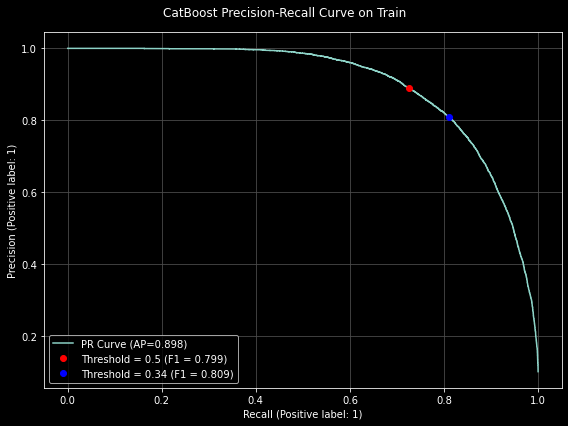

In [32]:
my_PrecisionRecallDisplay(
    y[train], y_proba_train, thr, 'CatBoost Precision-Recall Curve on Train')

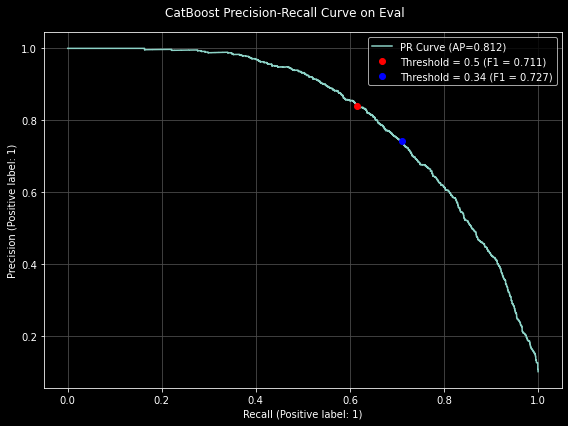

In [33]:
my_PrecisionRecallDisplay(
    y[eval], y_proba_eval, thr, 'CatBoost Precision-Recall Curve on Eval')

Кэтбусту с собственной векторизацией текста не удалось достичь целевого F1 на валидационной выборке. Поможем ему, подав в качестве фичей векторы TF-IDF лемматизированных комментариев.

In [34]:
cat = CatBoostClassifier(**params).fit(
    X=Pool(X_train, y[train]),
    eval_set=Pool(X_eval, y[eval]),
    use_best_model=True,
    verbose=50,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.104979
0:	learn: 0.6459976	test: 0.6670102	best: 0.6670102 (0)	total: 1.06s	remaining: 17m 42s
50:	learn: 0.7749053	test: 0.7697656	best: 0.7697656 (50)	total: 49.5s	remaining: 15m 21s
100:	learn: 0.8087657	test: 0.7972921	best: 0.7973403 (99)	total: 1m 39s	remaining: 14m 47s
150:	learn: 0.8312704	test: 0.8157308	best: 0.8157308 (150)	total: 2m 31s	remaining: 14m 9s
200:	learn: 0.8463085	test: 0.8260362	best: 0.8260362 (200)	total: 3m 20s	remaining: 13m 16s
250:	learn: 0.8582889	test: 0.8309908	best: 0.8309908 (250)	total: 4m 9s	remaining: 12m 24s
300:	learn: 0.8679161	test: 0.8357847	best: 0.8360144 (296)	total: 4m 55s	remaining: 11m 25s
350:	learn: 0.8754691	test: 0.8401526	best: 0.8401526 (350)	total: 5m 42s	remaining: 10m 33s
400:	learn: 0.8821139	test: 0.8425504	best: 0.8425780 (395)	total: 6m 28s	remaining: 9m 40s
450:	learn: 0.8882703	test: 0.8446655	best: 0.8446655 (450)	total: 7m 16s	remaining: 8m 50s
500:	learn: 0.8932524	test: 0.8456807	best: 0.8457944

In [36]:
y_proba_train = cat.predict_proba(Pool(X_train))[:, 1]
y_proba_eval = cat.predict_proba(Pool(X_eval))[:, 1]

In [37]:
print('Threshold = 0.5:')
print(f'   CatBoost F1 on train: {f1_score(y[train], y_proba_train >= .5):.3f}')
print(f'   CatBoost F1 on eval: {f1_score(y[eval], y_proba_eval >= .5):.3f}')

Threshold = 0.5:
   CatBoost F1 on train: 0.808
   CatBoost F1 on eval: 0.761


In [38]:
precision, recall, thresholds = precision_recall_curve(y[eval], y_proba_eval)

thr = thresholds[(precision*recall / (precision+recall)).argmax()]

print(f'Threshold = {thr:.2f}:')
print(f'   CatBoost F1 on train: {f1_score(y[train], y_proba_train >= thr):.3f}')
print(f'   CatBoost F1 on eval: {f1_score(y[eval], y_proba_eval >= thr):.3f}')

Threshold = 0.30:
   CatBoost F1 on train: 0.847
   CatBoost F1 on eval: 0.783


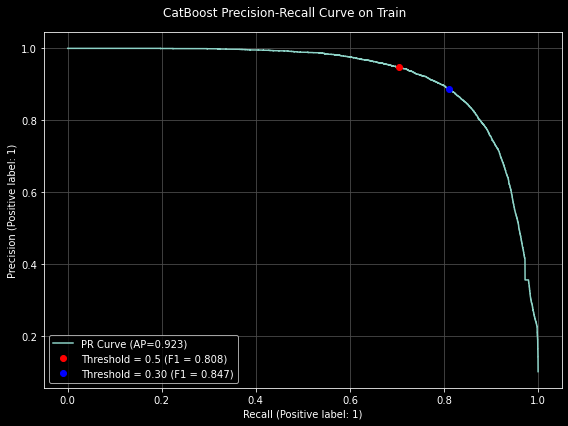

In [39]:
my_PrecisionRecallDisplay(
    y[train], y_proba_train, thr, 'CatBoost Precision-Recall Curve on Train')

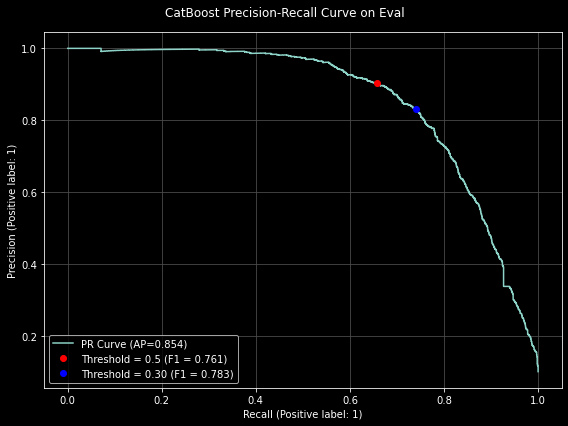

In [40]:
my_PrecisionRecallDisplay(
    y[eval], y_proba_eval, thr, 'CatBoost Precision-Recall Curve on Eval')

Теперь CatBoost справился. Проверим его финально на тестовой выборке.

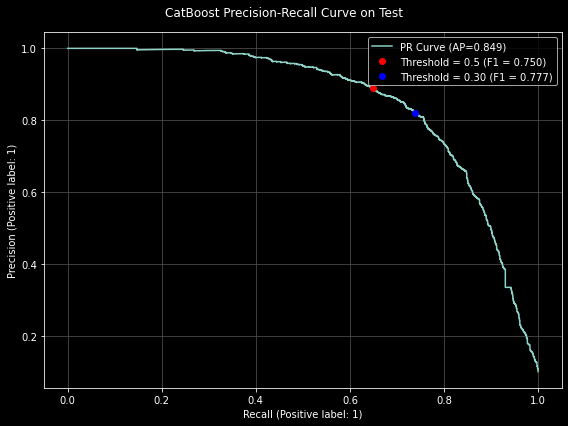

In [41]:
y_proba_test = cat.predict_proba(X_test)[:, 1]
my_PrecisionRecallDisplay(
    y[test], y_proba_test, thr, 'CatBoost Precision-Recall Curve on Test')

Все ок.

## Выводы

Модель логистической регрессии на векторах TF-IDF лемматизированных комментариев справилась с задачей даже лучше, чем CatBoost на тех же векторах: F1 0.790 против 0,783. CatBoost с собственной обработкой текста с задачей не справился: F1 0.727.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны